In [19]:
#Importing bunch of libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from keras.preprocessing import sequence

from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras import Input, layers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.preprocessing.image
from keras.models import load_model,Model
from keras.layers import Input,Embedding,Dropout,LSTM,Dense,add


In [2]:
#Loading the descriptions for the images.
datatxt=open('D:\\Machine_Learning_Projects_and_tools\\Image-captioning\\Flickr8k\\Flickr8k_text\\Flickr8k.token.txt','r')
txt=datatxt.read()
datatxt.close()
descriptions={}
for line in txt.split('\n'):
    tokens=line.split(' ')
    if len(line)<2:     #Removing s occuring alone after removing apostrophe.
        continue
    img_name,img_desc=tokens[0],tokens[1:]
    img_without_ext=img_name.split('.')[0]
    img_desc=' '.join(img_desc)
    if img_without_ext not in descriptions:
        descriptions[img_without_ext]=list()
    descriptions[img_without_ext].append(img_desc)
print('Loaded:',len(descriptions))
    
    



Loaded: 8092


In [3]:
#Cleaning the descriptions by converting them into small case for uniformity,removing punctuation,removing numbers if occur any.
table=str.maketrans('','',string.punctuation)
for key,desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc=desc_list[i].split()
        desc=[word.lower() for word in desc]
        desc=[word.translate(table) for word in desc]
        desc=[word for word in desc if len(word)>1]
        desc=[word for word in desc if word.isalpha()]
        desc_list[i]=' '.join(desc)

    

In [4]:
#Creating vocabulary.
vocabulary=set()
for key in descriptions.keys():
    [vocabulary.update(d.split()) for d in descriptions[key]]
print('Vocab Size:',len(vocabulary))

Vocab Size: 8680


In [5]:
#Save descriptions to a file.
lines=list()
for key,dsc_list in descriptions.items():
    for dsc in dsc_list:
        lines.append(key+' '+dsc)
    data='\n'.join(lines)
    file=open('descriptions.txt','w')
    file.write(data)
    file.close()
    



In [6]:
all_train_files_list=os.listdir('D:\\Machine_Learning_Projects_and_tools\\Image-captioning\\Flickr8k\\Flickr8k_Dataset\\Flicker8k_Dataset\\')
train_img_list=open('D:\\Machine_Learning_Projects_and_tools\\Image-captioning\\Flickr8k\\Flickr8k_text\\Flickr_8k.trainImages.txt','r').read().split('\n')
train_img_list=train_img_list[:-1]
test_img_list=open('D:\\Machine_Learning_Projects_and_tools\\Image-captioning\\Flickr8k\\Flickr8k_text\\Flickr_8k.testImages.txt','r').read().split('\n')
test_img_list=test_img_list[:-1]

train_descriptions={}
desc_file=open('descriptions.txt','r')
desc_file_content=desc_file.read()

for line in desc_file_content.split('\n'):
    tempsp=line.split(' ')
    img_name,img_desc=tempsp[0]+'.jpg',tempsp[1:]
    if img_name in train_img_list:
        if img_name not in train_descriptions:
            train_descriptions[img_name]=[]
        desc = 'startseq ' + ' '.join(img_desc) + ' endseq'
        train_descriptions[img_name].append(desc)
    





In [7]:
def preprocess(image_path):
    img=image.load_img(image_path,target_size=(299,299))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    img=preprocess_input(img)
    return img

In [10]:
incep_model=InceptionV3(weights='imagenet')
incep_not_last_layer=Model(incep_model.input,incep_model.layers[-2].output)

In [11]:
def extract_img_features(image):
    image=preprocess(image)
    feature_vecs=incep_not_last_layer.predict(image)
    feature_vecs=np.reshape(feature_vecs,feature_vecs.shape[1])
    return feature_vecs





    

In [12]:
all_training_captions=[]
for key,val in train_descriptions.items():
    for dsc in val:
        all_training_captions.append(dsc)
len(all_training_captions)

30000

In [13]:
#Consider only the words which occur 10 times.
word_count_threshold = 10
word_counts = {}
n_sents = 0
for sent in all_training_captions:
    n_sents += 1
    for word in sent.split(' '):
        word_counts[word] = word_counts.get(word, 0) + 1

vocab = [word for word in word_counts if word_counts[word] >= word_count_threshold]
print("Vocab size=",len(vocab))


Vocab size= 1631


In [14]:
#Creating word to index and index to word mapping.
idx2word={}
word2idx={}

idx=1
for word in vocab:
    word2idx[word]=idx
    idx2word[idx]=word
    idx+=1
    
vocab_size=len(word2idx)+1
vocab_size
    

1632

In [15]:
all_desc=list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]

max_len=max(len(d.split()) for d in lines)
max_len
    

32

In [20]:
#Lets build the model.

input1=Input(shape=(2048,))
do1=Dropout(0.5)(input1)
dl1=Dense(256,activation='relu')(do1)

input2=Input(shape=(max_len,))
emb1=Embedding(vocab_size,200,mask_zero=True)(input2)
do2=Dropout(0.5)(emb1)
ls1=LSTM(256)(do2)

dec1=add([dl1,ls1])
dec2=Dense(256,activation='relu')(dec1)
outputs=Dense(vocab_size,activation='softmax')(dec2)
model=Model(inputs=[input1,input2],outputs=outputs)

In [21]:
model.load_weights('./model_weights/model_30.h5')


In [29]:
def greedySearch(path):
    photo=extract_img_features(path)
    photo=photo.reshape((1,2048))
    in_text = 'startseq'
    for i in range(max_len):
        sequence = [word2idx[w] for w in in_text.split() if w in word2idx]
        sequence = pad_sequences([sequence], maxlen=max_len)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx2word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [23]:
images='D:\\Machine_Learning_Projects_and_tools\\Image-captioning\\Flickr8k\\Flickr8k_Dataset\\Flicker8k_Dataset\\'

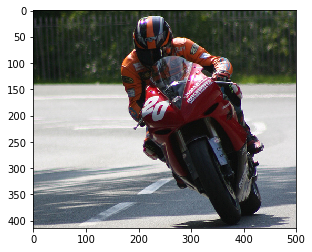

Caption: man in red helmet is riding red motorcycle


In [36]:
path='D:\\Machine_Learning_Projects_and_tools\\Image-captioning\\Flickr8k\\Flickr8k_Dataset\\Flicker8k_Dataset\\'+'166321294_4a5e68535f.jpg'
x=plt.imread(path)
plt.imshow(x)
plt.show()
print("Caption:",greedySearch(path))